In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
questions = pd.DataFrame.from_csv('questions.csv', index_col=None)
questions = questions.fillna(value=0)

#Otherwise would be throwing away valuable info from inactive posts
questions['ActiveLife'] = (pd.to_datetime(questions.LastActivity,format='%Y-%m-%d %H:%M:%S.%f')
                    - pd.to_datetime(questions.CreationDate,format='%Y-%m-%d %H:%M:%S.%f')).apply(lambda x: x.astype('timedelta64[D]').item().days)

questions['Age'] = (pd.Timestamp('20160314') # fixed collection date
                    - pd.to_datetime(questions.CreationDate,format='%Y-%m-%d %H:%M:%S.%f')).apply(lambda x: x.astype('timedelta64[D]').item().days)

questions['ViewAge'] = questions.ViewCount/(questions.Age)
questions['ReScore'] = questions.Score/(questions.Votes)
questions.drop(questions.columns[[1, 2]], axis=1, inplace=True)

#Take top 200 questions with highest View/Age ratio
questions = questions.sort_values(by=['ViewCount'],ascending=False).head(200)
questions.head()

,QuestionId,Score,AnsCount,CommentCount,FavCount,Votes,ViewCount,ActiveLife,Age,ViewAge,ReScore
758,2685,21,11,6,3,29,243589,1230,1314,185.379756,0.724138
1001,3642,7,1,6,3,10,123428,301,1048,117.774809,0.700000
234,827,21,4,4,7,28,110227,1372,1557,70.794477,0.750000
261,917,8,2,0,0,9,94176,1438,1551,60.719536,0.888889
670,2327,24,6,5,5,30,86727,1291,1391,62.348670,0.800000


## ViewCount vs (Score,AnsCount,FavCount, CommentCount)

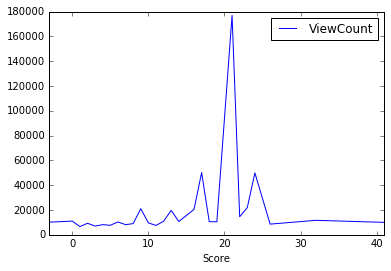

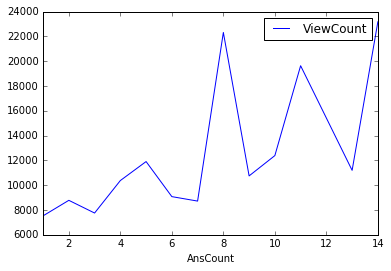

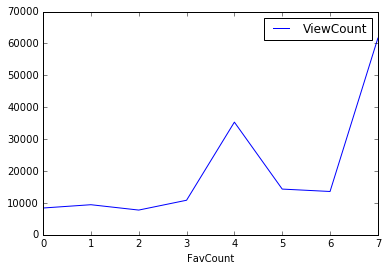

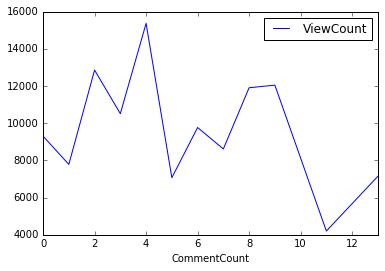

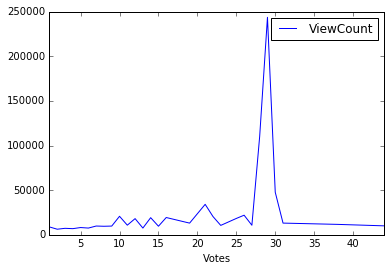

In [47]:
questions.sort_values(by='Score').groupby('Score').median()[['ViewCount']].plot()
questions.sort_values(by='AnsCount').groupby('AnsCount').median()[['ViewCount']].plot()
questions.sort_values(by='FavCount').groupby('FavCount').median()[['ViewCount']].plot()
questions.sort_values(by='CommentCount').groupby('CommentCount').median()[['ViewCount']].plot()
questions.sort_values(by='Votes').groupby('Votes').median()[['ViewCount']].plot()

c:\Users\Joel\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


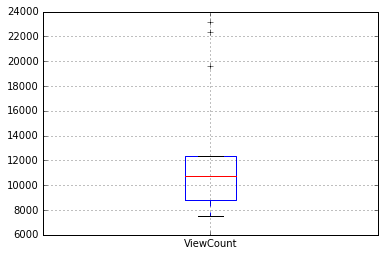

In [48]:
#bp = questions.sort_values(by='Score').groupby('Score').median()[['ViewCount']].boxplot()
bp = questions.sort_values(by='AnsCount').groupby('AnsCount').median()[['ViewCount']].boxplot()
#bp = questions.sort_values(by='FavCountB').groupby('FavCount').median()[['ViewCount']].boxplot()

## Correlation between covariates.
Q: Does richer context information yield better scores?

NB: ViewCount has a significant part of its mass (10k-12k) in the increasing part of the curve ViewCount vs AnsCount.
So, nb_answers might indeed be correlated (not in a linear fashion though) with PageViews.
On the other hand, note that PageViews are distributed practically in a uniform fashion over Scores. (e.g. Score != Profit)

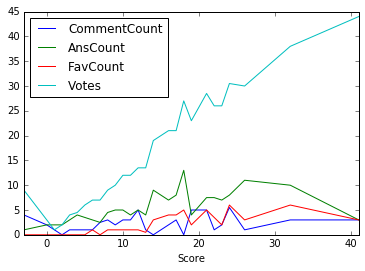

In [57]:
questions.sort_values(by='Score').groupby('Score').median()[['CommentCount','AnsCount','FavCount','Votes']].plot()

c:\Users\Joel\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


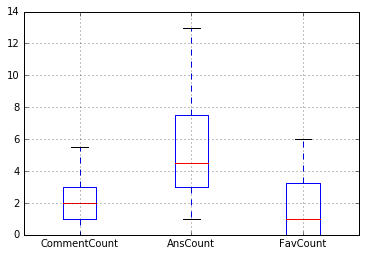

In [45]:
bp = questions.sort_values(by='Score').groupby('Score').median()[['CommentCount','AnsCount','FavCount']].boxplot()

In [66]:
print "Pearson r votes-score: ", questions['Votes'].corr(questions['Score'],method='pearson')

Pearson r votes-score:  0.966648799167


NB: Is there a correlation between favCount and CommentCount?

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [148]:
print "Correlation Views-AnsCount: ", questions['ViewCount'].corr(questions['AnsCount'],method='pearson')
print "Correlation Views-ReScore: ", questions['ReScore'].corr(np.log(questions['ViewCount']+1),method='pearson')

Correlation Views-AnsCount:  0.15942250975
Correlation Views-ReScore:  -0.0740559900551


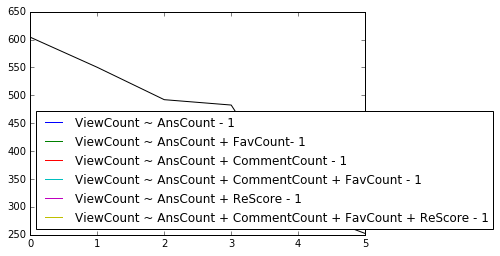

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

# ReScore + FavCount + AnsCount + CommentCount
r_method = sm.families.NegativeBinomial(link=sm.families.links.log)#sm.families.Poisson(link=sm.families.links.log)

fmls = ['ViewCount ~ AnsCount - 1','ViewCount ~ AnsCount + FavCount- 1','ViewCount ~ AnsCount + CommentCount - 1',
        'ViewCount ~ AnsCount + CommentCount + FavCount - 1'
        ,'ViewCount ~ AnsCount + ReScore - 1', 'ViewCount ~ AnsCount + CommentCount + FavCount + ReScore - 1']
devs = []
for fml in fmls:
    datas = questions
    mod = smf.glm(fml, data=datas,family=r_method, offset = np.log(datas['Age'] + 1))
    rslt = mod.fit(method='bfgs')
    devs.append(rslt.deviance)
    #print rslt.summary()

pd.Series(devs,index=fmls).to_frame().T.plot()
pd.Series(devs).plot(legend=False)
plt.savefig('AODevVignette.pdf',format='pdf')

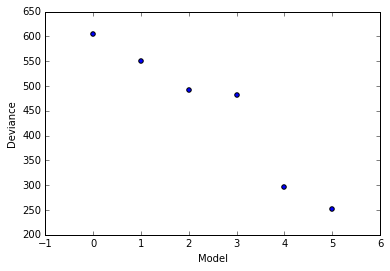

In [55]:
plt.scatter(range(len(devs)),devs)
plt.xlabel('Model')
plt.ylabel('Deviance')
plt.savefig('AODevianceView.pdf',format='pdf')

In [143]:
mod_ols = smf.ols(formula='np.log(ViewCount + 1) ~ ReScore + FavCount + AnsCount + CommentCount - 1', data=questions)
res = mod_ols.fit()
print res.summary()

                              OLS Regression Results                             
Dep. Variable:     np.log(ViewCount + 1)   R-squared:                       0.952
Model:                               OLS   Adj. R-squared:                  0.951
Method:                    Least Squares   F-statistic:                     976.2
Date:                   Thu, 17 Mar 2016   Prob (F-statistic):          3.58e-128
Time:                           03:10:40   Log-Likelihood:                -426.35
No. Observations:                    200   AIC:                             860.7
Df Residuals:                        196   BIC:                             873.9
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
ReScore          8

In [155]:
mod_poi = smf.glm('ViewCount ~ ReScore + FavCount + AnsCount + CommentCount - 1', data=questions,
                  family=sm.families.Poisson(link=sm.families.links.log)).fit(method='bfgs') #offset=np.log(Data['Offset'])
#print mod_poi.mle_retvals['converged']
print mod_poi.summary()


                 Generalized Linear Model Regression Results                  
Dep. Variable:              ViewCount   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -3.9887e+06
Date:                Thu, 17 Mar 2016   Deviance:                   8.7348e+06
Time:                        03:38:59   Pearson chi2:                 1.48e+09
No. Iterations:                    21                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
ReScore          9.1717      0.001   7468.842      0.000         9.169     9.174
FavCount         0.3147      0.000   1379.610 

In [145]:
huber_t = sm.RLM(np.log(questions.ViewAge + 1), questions[['ReScore','FavCount','AnsCount','CommentCount']], M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()

#print hub_results.params
#print hub_results.bse
#varnames = ['var_%d' % i for i in range(len(hub_results.params))]
print hub_results.summary()

                    Robust linear Model Regression Results                    
Dep. Variable:                ViewAge   No. Observations:                  200
Model:                            RLM   Df Residuals:                      196
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 17 Mar 2016                                         
Time:                        03:10:56                                         
No. Iterations:                    23                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
ReScore          2.0620      0.113     18.203   

In [152]:
from scipy.stats.stats import pearsonr
cor = pearsonr(hub_results.fittedvalues, np.log(questions.ViewAge + 1))[0]
print "R-squared for doubly-constrained model is: " + str(cor*cor)

R-squared for doubly-constrained model is: 0.000265764150139


In [151]:
hub_results?